In [19]:
# this code is based on [ref], which is released under the MIT licesne
# make sure you reference any code you have studied as above here

# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

# hyperparameters
EPOCHS = 10
batch_size  = 64
n_channels  = 3
latent_size = 32
dataset = 'mnist'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
# optional Google drive integration - this will allow you to save and resume training, and may speed up redownloading the dataset
# from google.colab import drive
#drive.mount('/content/drive')

In [21]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets

# cifar10 is a collection of 32x32 images by default
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('./training/cifar10', train=True, download=True, transform=torchvision.transforms
                                     .Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 32x32 MNIST for simpler testing
if dataset == 'mnist':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./training/mnist', train=True, download=True, transform=torchvision.transforms
                                     .Compose([
            torchvision.transforms.Resize(32),
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    n_channels = 1

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10

# stl10 is a collection of 96x96 images by default
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('./training/stl10', split='train+unlabeled', download=True, transform=torchvision
                                   .transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

train_iterator = iter(cycle(train_loader))

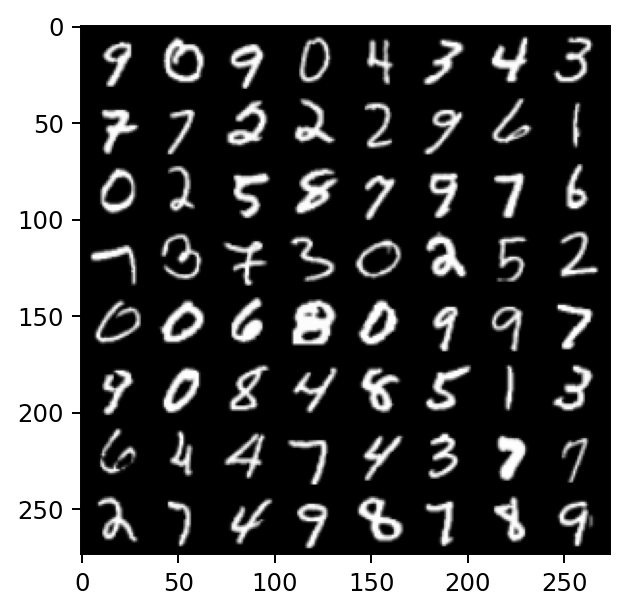

In [22]:
# let's view some of the training data

plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)

plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

**Define a simple convolutional autoencoder**

In [23]:
# simple block of convolution, batchnorm, and leakyrelu
class ConvBlock(nn.Module):
    def __init__(self, in_f, out_f,stride=1):
        super(ConvBlock, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)
class ConvTransBlock(nn.Module):
    def __init__(self, in_f, out_f,stride=1):
        super(ConvTransBlock, self).__init__()
        self.f = nn.Sequential(
            nn.ConvTranspose2d(in_f, out_f, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self,x):
        return self.f(x)

# define the model
# https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
class Autoencoder(nn.Module):
    def __init__(self, f=16):
        super().__init__()

        self.dropout = nn.Dropout(0.25)

        # [(W−K+2P)/S]+1 == conv_output ((width - kernel size + 2*padding)/stride) + 1
        self.encoder = nn.Sequential(
            # 3 -> 32
            ConvBlock(n_channels,f),
            self.dropout,
            nn.MaxPool2d(kernel_size=(2,2)),
            # 32 -> 64
            ConvBlock(f,f*2),
            self.dropout,
            nn.MaxPool2d(kernel_size=(2,2)),
            # 64 -> 128
            ConvBlock(f*2,f*4),
            self.dropout,
            nn.MaxPool2d(kernel_size=(2,2)),
            # 128 -> 256
            ConvBlock(f*4,f*8),
            self.dropout,
            nn.MaxPool2d(kernel_size=(2,2)),
            # 256 -> 512
            ConvBlock(f*8,f*16),
            self.dropout,
            # 512 -> 1024
            ConvBlock(f*16,1024),
            self.dropout
        )

        # self.encoder = nn.Sequential(
        #     ConvBlock(n_channels, f),
        #     nn.MaxPool2d(kernel_size=(2,2)), # output = 16x16 (if cifar10, 48x48 if stl10)
        #     ConvBlock(f  ,f*2),
        #     nn.MaxPool2d(kernel_size=(2,2)), # output = 8x8
        #     ConvBlock(f*2,f*4),
        #     nn.MaxPool2d(kernel_size=(2,2)), # output = 4x4
        #     ConvBlock(f*4,f*4),
        #     nn.MaxPool2d(kernel_size=(2,2)), # output = 2x2
        #     ConvBlock(f*4,f*4),
        #     nn.MaxPool2d(kernel_size=(2,2)), # output = 1x1
        #     ConvBlock(f*4,latent_size),
        # )

        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_size,)
        #     # nn.Conv2d(f,n_channels, 3,1,1),
        #     # nn.Sigmoid()
        # )

        self.fc_mu = nn.Linear(4096,latent_size)
        self.fc_var = nn.Linear(4096,latent_size)


        self.decode_latent_space = nn.Linear(latent_size,4096)

        self.decoder = nn.Sequential(
            ConvTransBlock(1024,f*16),
            self.dropout,
            nn.Upsample(scale_factor=2),
            ConvTransBlock(f*16,f*8),
            nn.Upsample(scale_factor=2),
            self.dropout,
            ConvTransBlock(f*8,f*4),
            nn.Upsample(scale_factor=2),
            self.dropout,
            ConvTransBlock(f*4,f*2),
            nn.Upsample(scale_factor=2),
            self.dropout,
            ConvTransBlock(f*2,f),
            # nn.Upsample(scale_factor=2),
            # ConvTransBlock(f,n_channels)
        )

        self.final_layer = nn.Sequential(
            ConvTransBlock(f,f),
            nn.Conv2d(f,n_channels,kernel_size=(3,3),padding=1),
            nn.Tanh()
        )

    def encode(self, inp):

        # print("input shape: ",inp.shape)
        encoded = self.encoder(inp)

        # print("encoded shape1: ",encoded.shape)

        encoded = torch.flatten(encoded,start_dim=1)
        # print("encoded shape2: ",encoded.shape)

        mu = self.fc_mu(encoded)
        # mu = self.dropout(mu)
        log_var = self.fc_var(encoded)
        # log_var = self.dropout(log_var)

        return (mu,log_var)

    def reparameterise(self, mu, log_var):
        st_dev = torch.exp(0.5*log_var)
        eps = torch.randn_like(st_dev)
        # eps = 1
        return mu + (st_dev * eps)

    def decode(self, inp):
        decoded = self.decode_latent_space(inp)
        decoded = self.dropout(decoded)
        # print("decoded shape1: ",decoded.shape)
        decoded = decoded.view(64,1024,2,2)
        # print("decoded shape2: ",decoded.shape)
        decoded = self.decoder(decoded)
        decoded = self.dropout(decoded)
        # print("decoded shape3: ",decoded.shape)
        decoded = self.final_layer(decoded)
        # print("decoded shape4: ",decoded.shape)
        return decoded

    def loss_fn(self):
        pass

    def forward(self, inp):
        mu, log_var = self.encode(inp)
        z = self.reparameterise(mu, log_var)
        return  (self.decode(z), inp, mu, log_var)




A = Autoencoder(32).to(device)
print(f'> Number of autoencoder parameters {len(torch.nn.utils.parameters_to_vector(A.parameters()))}')
optimiser = torch.optim.Adam(A.parameters(), lr=0.001, weight_decay=0.0005)
epoch = 0

> Number of autoencoder parameters 12986913


**Main training loop**

100%|██████████| 100/100 [03:05<00:00,  1.86s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 100/100 [03:04<00:00,  1.85s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 100/100 [03:12<00:00,  1.92s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 100/100 [03:04<00:00,  1.85s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 100/100 [03:04<00:00,  1.84s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 100/100 [03:05<00:00,  

loss tensor(0.1712, grad_fn=<MeanBackward0>)
loss tensor(0.1446, grad_fn=<MeanBackward0>)
loss tensor(0.1398, grad_fn=<MeanBackward0>)
loss tensor(0.1313, grad_fn=<MeanBackward0>)
loss tensor(0.1433, grad_fn=<MeanBackward0>)
loss tensor(0.1279, grad_fn=<MeanBackward0>)
loss tensor(0.1484, grad_fn=<MeanBackward0>)
loss tensor(0.1362, grad_fn=<MeanBackward0>)
loss tensor(0.1238, grad_fn=<MeanBackward0>)
loss tensor(0.1198, grad_fn=<MeanBackward0>)


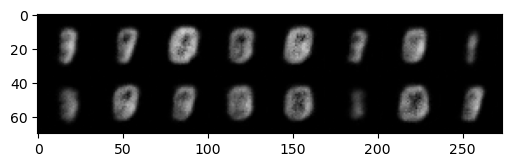

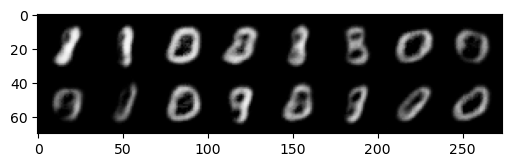

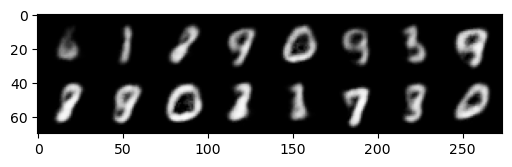

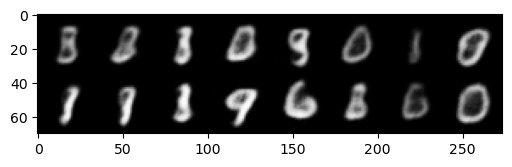

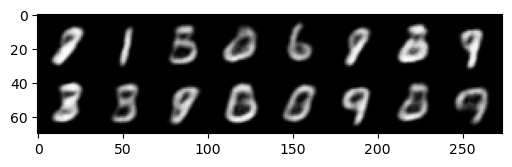

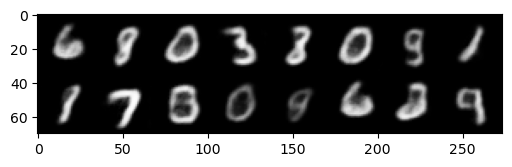

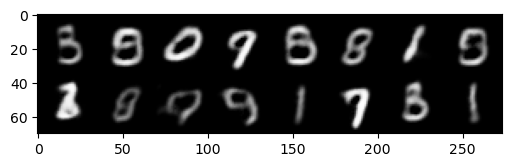

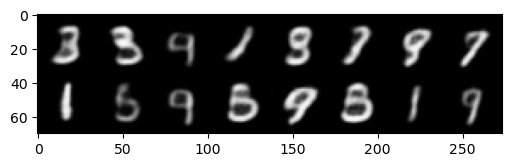

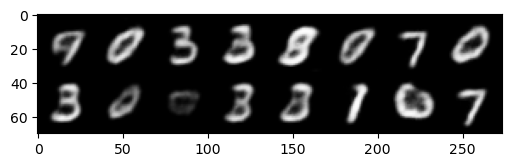

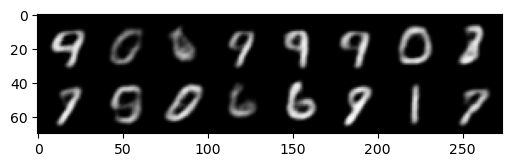

In [24]:
# training loop, you will want to train for more than 10 here!
for i in range(EPOCHS):
    # array(s) for the performance measures
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in tqdm(range(100)):
    # for i in range(10):
        # sample x from the dataset
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # do the forward pass with mean squared error
        z = A.forward(x)
        x_hat = z[0]
        mu = z[2]
        log_var = z[3]

        # print(x.shape)
        # x_hat = A.decode(z)
        # print(x_hat.shape)


        loss = F.mse_loss(x,x_hat)
        L_prior = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        l1_loss = F.l1_loss(x,x_hat)

        # loss = loss + (L_prior*0.005) + l1_loss
        loss = loss + L_prior*0.001 + l1_loss
        # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # collect stats
        loss_arr = np.append(loss_arr, loss.item())

    # sample your model (autoencoders are not good at this)
    z = torch.randn(64,latent_size)
    g = A.decode(z)

    # plot some examples
    print('loss ' + str(loss.mean()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:16]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm
               .binary)
    plt.show()
    plt.pause(0.0001)


torch.Size([8, 4])


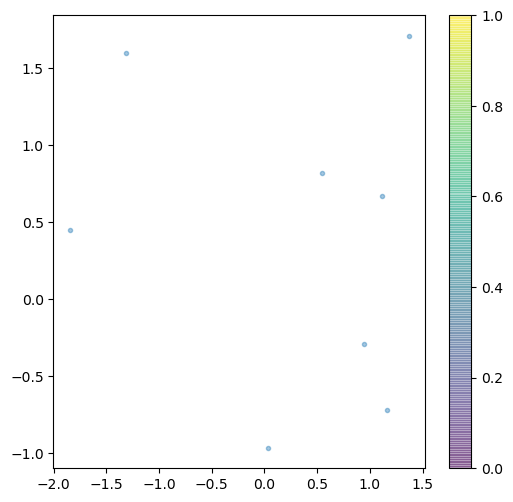

In [25]:
# x,t = next(train_iterator)
# x,t = x.to(device), t.to(device)
#
# z_test = A.forward(x)
#
# x_hat = z[0]
# mu = z[2]
#
#
# plt.figure(figsize=(6, 6))
# mu = mu.view(8,4)
# print(mu.shape)
# plt.scatter(mu[:, 0], mu[:, 1],
#             alpha=.4, s=3**2, cmap='viridis')
# plt.colorbar()
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


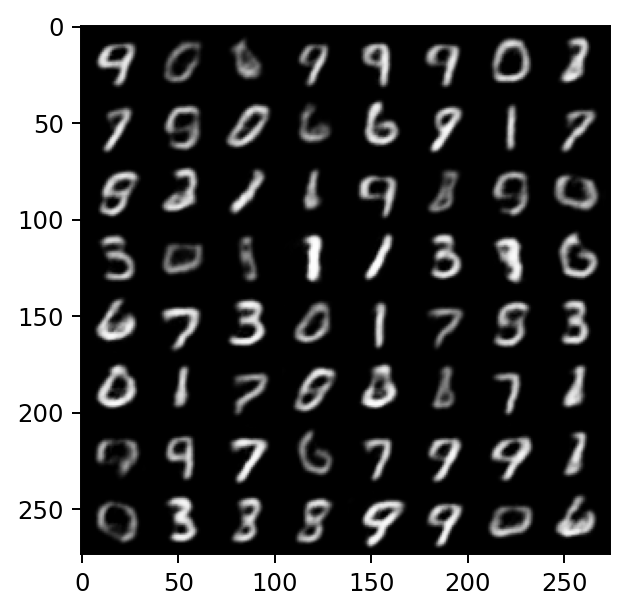

In [26]:
# now show your best batch of data for the submission, right click and save the image for your report
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [27]:
# optional example code to save your training progress for resuming later if you authenticated Google Drive previously
torch.save({'A':A.state_dict(), 'optimiser':optimiser.state_dict(), 'epoch':epoch}, './training/save.chkpt')

In [28]:
# optional example to resume training if you authenticated Google Drive previously
params = torch.load('./training/save.chkpt')
A.load_state_dict(params['A'])
optimiser.load_state_dict(params['optimiser'])
epoch = params['epoch']
